In [2]:
#data import and cleanup
import kagglehub
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from kagglehub import KaggleDatasetAdapter
file_path = "matches.csv"
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "saurav9786/indian-premier-league-match-analysis",
  file_path )
df.drop(columns='umpire3',inplace=True)
df['city']=df['city'].fillna('in India')
df['player_of_match']=df['player_of_match'].fillna('Not Awarded')
df['winner']=df['winner'].fillna('Unknown')
df[['umpire1','umpire2']]=df[['umpire1','umpire2']].fillna('Not Allotted')
import pandas as pd
df['date']=pd.to_datetime(df['date'],format="mixed",dayfirst=True)
df['month_of_match']= df['date'].dt.month_name()

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#names of teams were changed across season
team_mapping = {
    "Delhi Daredevils": "Delhi Capitals",
    "Rising Pune Supergiant": "Pune Franchise",
    "Rising Pune Supergiants": "Pune Franchise",
    "Pune Warriors": "Pune Franchise",
    "Gujarat Lions": "Gujarat Titans"
}

df['team1'] = df['team1'].replace(team_mapping)
df['team2'] = df['team2'].replace(team_mapping)
df['winner'] = df['winner'].replace(team_mapping)
df['toss_winner'] = df['toss_winner'].replace(team_mapping)


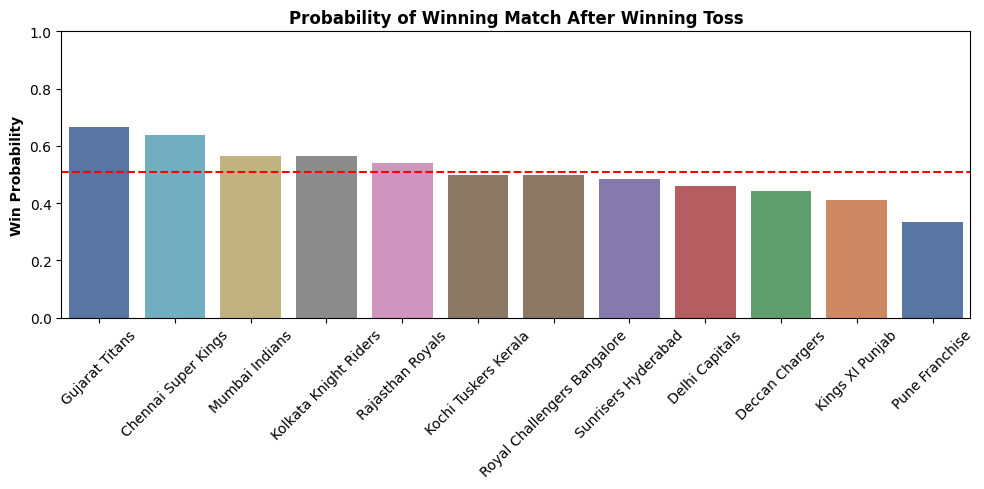

In [4]:
df_toss_win_prob = (
    df.assign(win_after_toss = df['toss_winner'] == df['winner'])
      .groupby('toss_winner')['win_after_toss']
      .mean()
      .reset_index(name='win_probability')
      .sort_values('win_probability', ascending=False)
)
#probablity plot of teams
plt.figure(figsize=(10,5))
sns.barplot(
    data=df_toss_win_prob,
    x='toss_winner',
    y='win_probability',
    hue='win_probability',
    palette='deep',
    legend=False
)
plt.title('Probability of Winning Match After Winning Toss', fontweight='bold')
plt.xlabel('')
plt.ylabel('Win Probability', fontweight='bold')
plt.ylim(0,1)
plt.axhline(df_toss_win_prob['win_probability'].mean(),
            color='red', linestyle='--')
plt.xticks(rotation=45,fontsize=10)
plt.tight_layout()
plt.show()


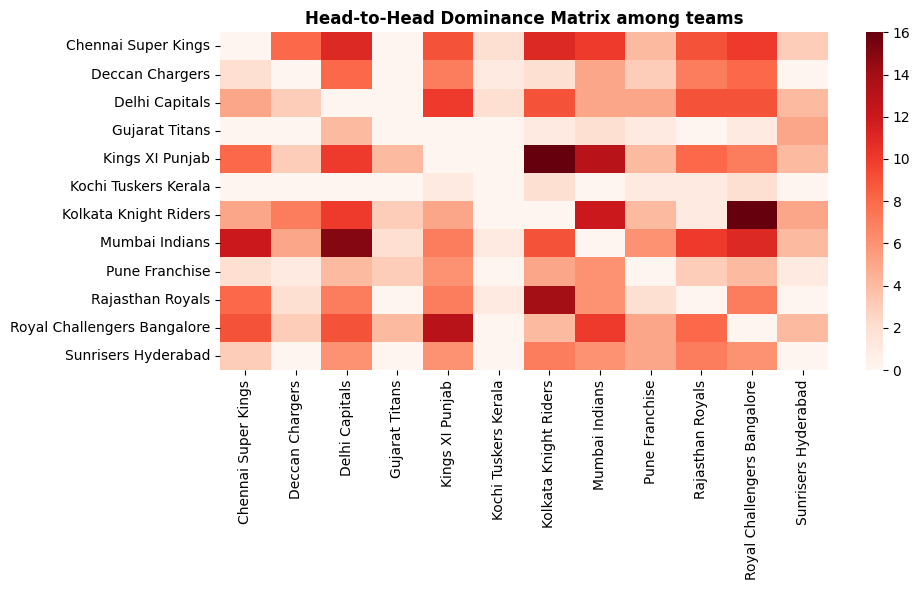

In [ ]:
#dataframe of head-to-head teams
df_h2h = (
    df.groupby(['team1', 'team2', 'winner'])
      .size()
      .reset_index(name='count')
)
#dealing with no result rows
df_h2h = df_h2h[df_h2h['winner'].isin(df['team1'].unique())]
h2h_pivot = (
    df_h2h.pivot_table(
        index='team1',
        columns='team2',
        values='count',
        aggfunc='sum',
        fill_value=0
    )
)
#Darker the cell dominant is the strategy, Symetrical cells equal compititors
plt.figure(figsize=(10,6))
sns.heatmap(
    h2h_pivot,
    cmap='Reds',
    annot=False
)
plt.title('Head-to-Head Dominance Matrix among teams', fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()


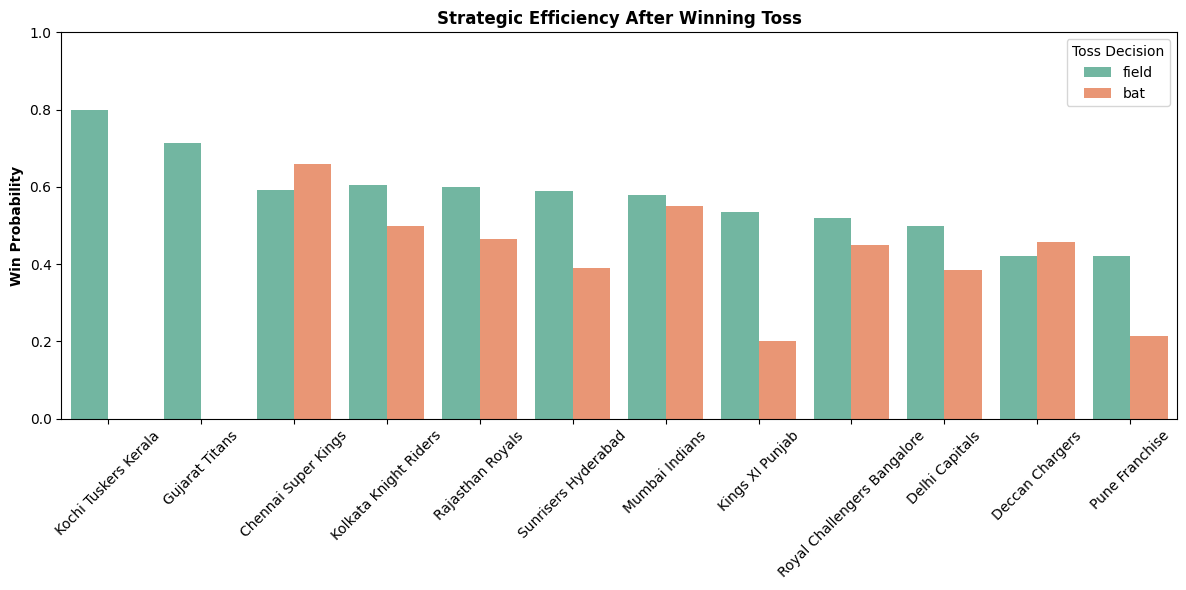

In [9]:
df_strategy = (
    df.assign(win = df['winner'] == df['toss_winner'])
      .groupby(['toss_winner', 'toss_decision'])['win']
      .mean()
      .reset_index()
      .sort_values('win', ascending=False)
)
#Barplot for 
plt.figure(figsize=(12,6))
sns.barplot(
    data=df_strategy,
    x='toss_winner',
    y='win',
    hue='toss_decision',
    palette='Set2'
)
plt.title('Strategic Efficiency After Winning Toss', fontweight='bold')
plt.xlabel('')
plt.ylabel('Win Probability', fontweight='bold')
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.legend(title='Toss Decision')
plt.tight_layout()
plt.show()


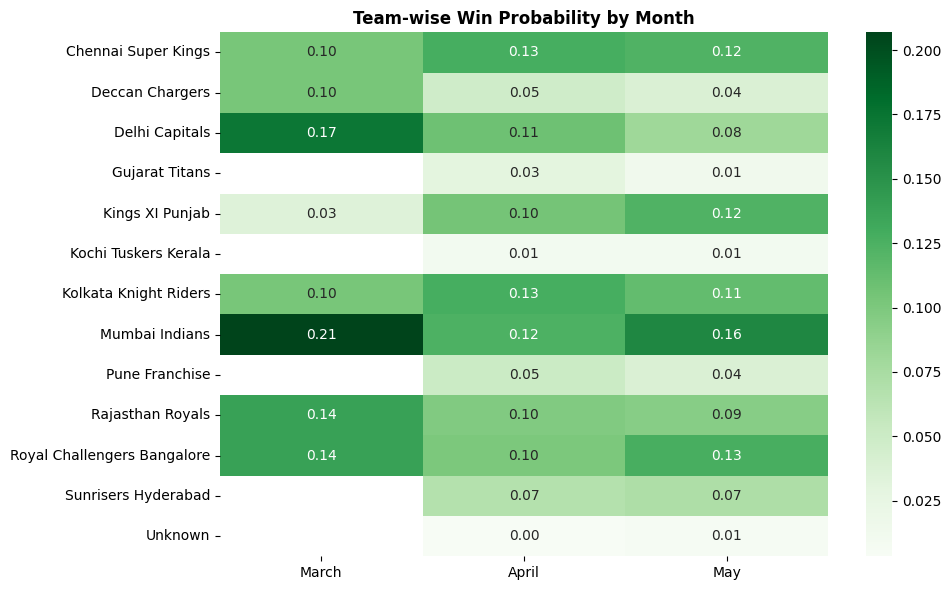

In [7]:
#number of wins for each team in each month
df_team_month_prob = (
    df.groupby(['month_of_match', 'winner'])
      .size()
      .reset_index(name='wins')
)
#total matches played in each month
df_month_total = (
    df.groupby('month_of_match')
      .size()
      .reset_index(name='total_matches')
)
#Merging win counts with total match counts
df_team_month_prob = df_team_month_prob.merge(
    df_month_total,
    on='month_of_match'
)
#conditional win probability
df_team_month_prob['win_probability'] = (
    df_team_month_prob['wins'] / df_team_month_prob['total_matches']
)
month_order = ['March', 'April', 'May']
#pivot table for plot
heatmap_data = (
    df_team_month_prob
    .pivot(index='winner', columns='month_of_match', values='win_probability')
    .reindex(columns=month_order)
)
#high probablity darker shade.
plt.figure(figsize=(10,6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.2f',
    cmap='Greens'
)
plt.title('Team-wise Win Probability by Month',
          fontweight='bold')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()
